<a href="https://colab.research.google.com/github/rafaekasetiyawan/polynomial-regression_auto-mpg-dataset/blob/main/polynomial_regression_auto_mpg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PROJECT: POLYNOMIAL REGRESSION (AUTO MPG DATASET)**

**Fokus: Pemodelan Non-Linear antara horsepower / weight vs mpg**

**Konsep Umum Polynomial Regression**

Polynomial Regression adalah bentuk ekstensi dari regresi linear,
di mana hubungan antara variabel prediktor xdan target y tidak harus linear.
Persamaan umumnya:

$$y ̂=β_0+β_1 x+β_2 x^2+β_3 x^3+⋯+β_d x^d$$

di mana:

  $d$= degree polynomial (orde pangkat tertinggi)

  $β_i$= koefisien regresi yang diestimasi oleh model

  $x$= fitur prediktor (contoh: horsepower)

  $y$= target (mpg)


**Langkah 1 — Load Dataset & Informasi Dasar**

Tujuan:
Menyiapkan dan memahami data sebelum modeling.

Proses utama:

1. Membaca dataset auto-mpg.csv dengan pandas.read_csv().

2. Membersihkan data:

    * Nilai '?' diubah menjadi NaN.

    * Baris dengan NaN pada kolom horsepower dihapus.

    * Kolom horsepower dikonversi ke float.

3. Menampilkan informasi dataset (df.info() dan df.head()) untuk melihat tipe data & contoh baris.

    * Visualisasi korelasi numerik menggunakan heatmap (sns.heatmap(df.corr())):

    * Menunjukkan hubungan antar variabel numerik

=== 1. LOAD DATASET & INFORMASI DASAR ===

--- Info Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB
None

--- Contoh Dataset ---
    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0    3504          12.0   
1  15.0          8         350.0       165.0    3693          11.5   
2  18.0          8         318.0       150.0    3436     

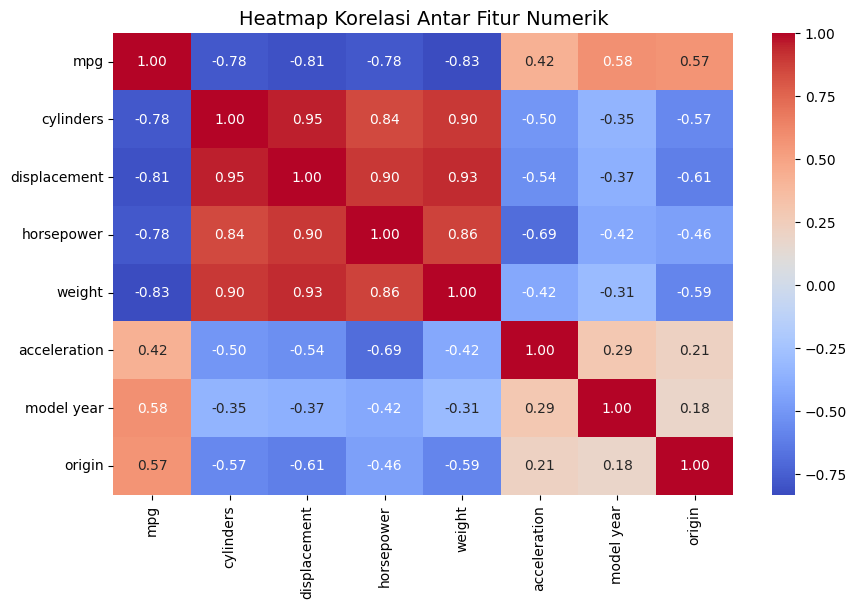

In [1]:
# Import library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# ===============================================================
# 1. LOAD DATASET & INFORMASI DASAR
# ===============================================================
print("=== 1. LOAD DATASET & INFORMASI DASAR ===")

# Ganti path sesuai lokasi dataset kamu
df = pd.read_csv("auto-mpg.csv")

# Cek informasi dataset
print("\n--- Info Dataset ---")
print(df.info())

# Hapus baris kosong
df = df.replace("?", np.nan)
df = df.dropna(subset=["horsepower"])
df["horsepower"] = df["horsepower"].astype(float)

# Tampilkan contoh data
print("\n--- Contoh Dataset ---")
print(df.head())

# Tampilkan Heatmap Korelari antar fitur
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap Korelasi Antar Fitur Numerik", fontsize=14)
plt.show()

# Pilih fitur dan target
fitur_list = ['horsepower', 'weight']
target = 'mpg'


**Langkah 2 — Persiapan Data untuk Model**

Tujuan:
Menormalkan fitur agar setiap variabel memiliki skala yang sebanding dan mencegah dominasi fitur tertentu.

Proses utama:

Fitur yang digunakan:


$$X=[horsepower,weight]$$

Target:

$$y= [mpg]$$

Menggunakan StandardScaler dari sklearn:


$$z = \frac{x-\mu}{\sigma}$$

sehingga tiap kolom memiliki rata-rata 0 dan standar deviasi 1.

In [2]:
# ===============================================================
# 2️. PERSIAPAN DATA UNTUK MODEL
# ===============================================================
print("\n=== 2. PERSIAPAN DATA UNTUK MODEL ===")

# Normalisasi fitur
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[fitur_list] = scaler.fit_transform(df[fitur_list])

print("\n--- Statistik Setelah Normalisasi ---")
print(df_scaled[fitur_list].describe())


=== 2. PERSIAPAN DATA UNTUK MODEL ===

--- Statistik Setelah Normalisasi ---
         horsepower        weight
count  3.920000e+02  3.920000e+02
mean  -1.812609e-16 -1.812609e-17
std    1.001278e+00  1.001278e+00
min   -1.520975e+00 -1.608575e+00
25%   -7.665929e-01 -8.868535e-01
50%   -2.853488e-01 -2.052109e-01
75%    5.600800e-01  7.510927e-01
max    3.265452e+00  2.549061e+00


Langkah 3 — Menentukan Degree Optimal (Derajat Polinomial)

Tujuan:Menemukan derajat polinomial terbaik yang memberikan keseimbangan antara fit (akurasi) dan generalization (tidak overfitting).

Proses utama:

1. Untuk setiap fitur (horsepower dan weight):

    * Membangun model polynomial regression dengan derajat $d=1$ sampai $d=10$.

    * Menggunakan $\text{train\_test\_split}$ (80/20) untuk memisahkan data.

    * Menghitung $\mathbf{R^2}$ untuk data train dan test.

$$\mathbf{R^2 = 1 - \frac{\sum (y-\hat{y})^2}{\sum (y-\bar{y})^2}}$$


2. Menyimpan hasil $\text{R}^2$ pada setiap degree, lalu memplot:

    * Garis biru $\rightarrow$ $\text{R}^2$ train
    * Garis merah $\rightarrow$ $\text{R}^2$ test(Terlihat titik overfitting jika $\text{R}^2_{\text{train}}$ naik terus, tapi $\text{R}^2_{\text{test}}$ turun.)
    
3. Menentukan degree optimal berdasarkan nilai
$\text{R}^2_{\text{test}}$ tertinggi.

    Derajat Polinomial Optimal ($\mathbf{d}$ terbaik) adalah derajat yang menghasilkan nilai Koefisien Determinasi ($\mathbf{R^2}$) tertinggi pada data Pengujian.


$$\mathbf{\text{degree optimal} = \arg\max_d R^2_{\text{test}}(d)}$$


=== Analisis untuk fitur: horsepower ===


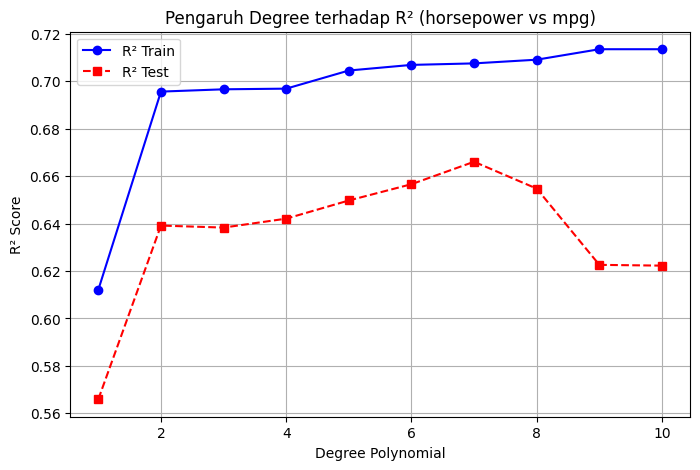

Degree optimal untuk horsepower: 7, R² test tertinggi = 0.6661

=== Analisis untuk fitur: weight ===


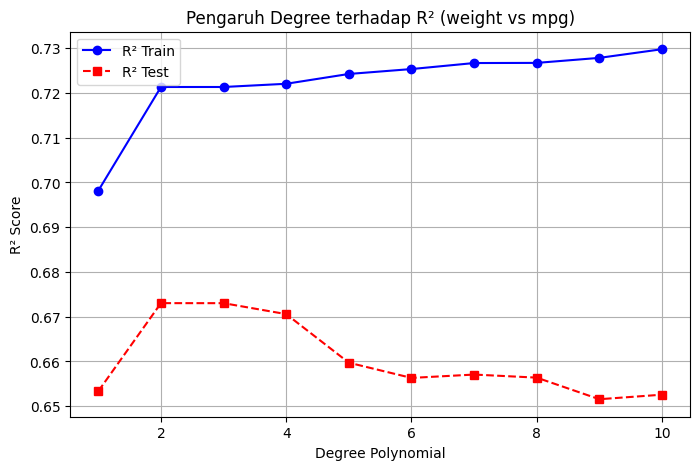

Degree optimal untuk weight: 2, R² test tertinggi = 0.6730

=== Degree Optimal per Fitur ===
{'horsepower': 7, 'weight': 2}


In [3]:
# ===============================================================
# 3️. CARI DEGREE OPTIMAL (Visualisasi R² per Degree)
# ===============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

def cari_degree_terbaik(X, y, max_degree=100, nama_fitur=""):
    r2_train_list, r2_test_list = [], []
    degrees = list(range(1, max_degree+1))

    for d in degrees:
        poly = PolynomialFeatures(degree=d)
        X_poly = poly.fit_transform(X.reshape(-1, 1))
        X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

        model = LinearRegression().fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        r2_train_list.append(r2_score(y_train, y_pred_train))
        r2_test_list.append(r2_score(y_test, y_pred_test))

    # Plot
    plt.figure(figsize=(8,5))
    plt.plot(degrees, r2_train_list, 'o-', color='blue', label='R² Train')
    plt.plot(degrees, r2_test_list, 's--', color='red', label='R² Test')
    plt.title(f'Pengaruh Degree terhadap R² ({nama_fitur} vs mpg)')
    plt.xlabel('Degree Polynomial')
    plt.ylabel('R² Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    best_degree = degrees[np.argmax(r2_test_list)]
    print(f"Degree optimal untuk {nama_fitur}: {best_degree}, R² test tertinggi = {max(r2_test_list):.4f}")
    return best_degree

# ===============================================================
# PROSES UNTUK SETIAP FITUR
# ===============================================================
hasil_degree = {}

for fitur in fitur_list:
    print(f"\n=== Analisis untuk fitur: {fitur} ===")
    X = df_scaled[fitur].values
    y = df_scaled[target] if target in df_scaled else df[target]

    # Cari degree terbaik
    best_deg = cari_degree_terbaik(X, y, max_degree=10, nama_fitur=fitur)
    hasil_degree[fitur] = best_deg

print("\n=== Degree Optimal per Fitur ===")
print(hasil_degree)


**Langkah 4 — Model Final Polynomial Regression**

Tujuan:Membangun model akhir dengan derajat terbaik dan mengevaluasi performanya.

Proses utama:
1. Untuk setiap fitur:
    * Gunakan degree terbaik ($d$) dari Langkah 3.
    * Lakukan Transformasi Fitur:
  $$\mathbf{\phi(z) = [1, z, z^2, \dots, z^d]}$$

    * Latih model linear:   

  $$\mathbf{\hat{\beta} = (X^T X)^{-1} X^T y}$$
    
  2. Lakukan prediksi dan evaluasi:
     *  $\text{R}^2$ train/test
     * $\text{RMSE}$ train/test
        
  $$\mathbf{\mathrm{RMSE} = \sqrt{\frac{1}{n}\sum_i (y_i - \hat{y}_i)^2}}$$
        
  3. Visualisasi kurva hasil model terhadap data asli.
  4. Menyimpan hasil evaluasi ke dalam tabel ringkasan.


=== Analisis untuk fitur: horsepower ===


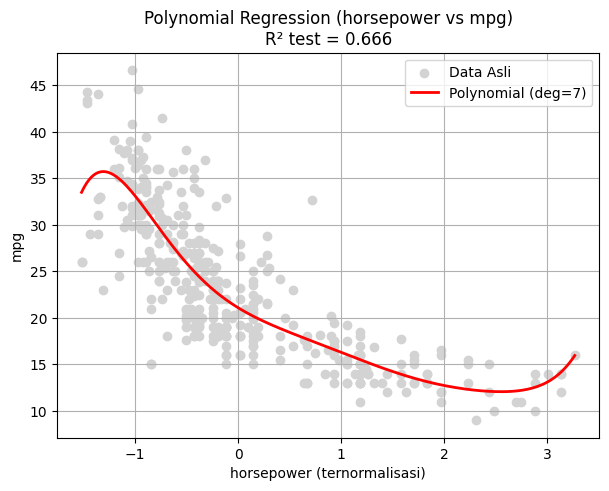


=== Analisis untuk fitur: weight ===


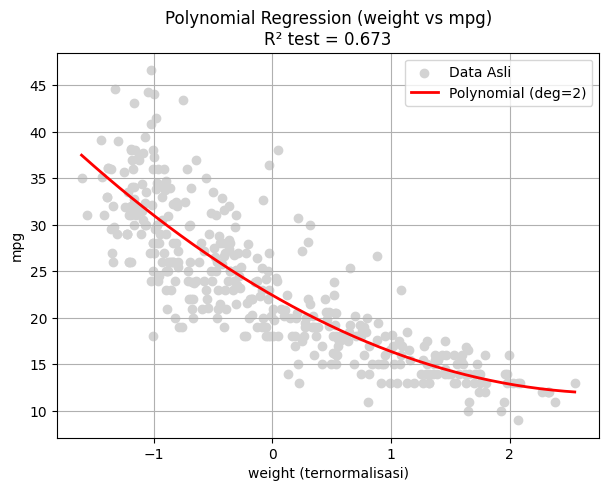


=== RINGKASAN HASIL ===
            degree  r2_train   r2_test  rmse_train  rmse_test
horsepower     7.0  0.707537  0.666073    4.295852   4.128419
weight         2.0  0.721346  0.673023    4.193205   4.085226


In [4]:
# ===========================================================
# 4. MODEL FINAL POLYNOMIAL REGRESSION DENGAN DEGREE TERBAIK
# ===========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

hasil_model = {}

for fitur in fitur_list:
    print(f"\n=== Analisis untuk fitur: {fitur} ===")
    X = df_scaled[fitur].values
    y = df_scaled[target] if target in df_scaled else df[target]

    # Gunakan degree terbaik dari hasil langkah 3
    best_deg = hasil_degree[fitur]

    # Buat model final dengan degree terbaik
    poly = PolynomialFeatures(degree=best_deg)
    X_poly = poly.fit_transform(X.reshape(-1, 1))
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)
    model = LinearRegression().fit(X_train, y_train)

    # Prediksi
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Evaluasi
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    # Simpan hasil
    hasil_model[fitur] = {
        'degree': best_deg,
        'r2_train': r2_train,
        'r2_test': r2_test,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test
    }

    # VISUALISASI HASIL MODEL FINAL
    plt.figure(figsize=(7,5))
    plt.scatter(X, y, color='lightgray', label='Data Asli')
    X_plot = np.linspace(X.min(), X.max(), 200).reshape(-1,1)
    X_plot_poly = poly.transform(X_plot)
    y_plot = model.predict(X_plot_poly)
    plt.plot(X_plot, y_plot, color='red', linewidth=2, label=f'Polynomial (deg={best_deg})')
    plt.xlabel(f'{fitur} (ternormalisasi)')
    plt.ylabel('mpg')
    plt.title(f'Polynomial Regression ({fitur} vs mpg)\nR² test = {r2_test:.3f}')
    plt.legend()
    plt.grid(True)
    plt.show()

# RINGKASAN HASIL
print("\n=== RINGKASAN HASIL ===")
ringkasan = pd.DataFrame(hasil_model).T
print(ringkasan)
